In [ ]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install scipy
!pip install matplotlib
!pip install splearn
!pip install tensorflow
!pip install keras

In [ ]:
import os
import numpy as np
import scipy.io as sio
from typing import Tuple
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, sosfiltfilt, freqz
from splearn.fourier import fast_fourier_transform

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Benchmark():
    _CHANNELS = [
        'FP1','FPZ','FP2','AF3','AF4','F7','F5','F3','F1','FZ','F2',
        'F4','F6','F8','FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6',
        'FT8','T7','C5','C3','C1','Cz','C2','C4','C6','T8','M1','TP7',
        'CP5','CP3','CP1','CPZ','CP2','CP4','CP6','TP8','M2','P7','P5',
        'P3','P1','PZ','P2','P4','P6','P8','PO7','PO5','PO3','POz','PO4',
        'PO6','PO8','CB1','O1','Oz','O2','CB2'
    ]

    _FREQS = [
        8, 9, 10, 11, 12, 13, 14, 15,
        8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 14.2, 15.2,
        8.4, 9.4, 10.4, 11.4, 12.4, 13.4, 14.4, 15.4,
        8.6, 9.6, 10.6, 11.6, 12.6, 13.6, 14.6, 15.6,
        8.8, 9.8, 10.8, 11.8, 12.8, 13.8, 14.8, 15.8
    ]

    _PHASES = [
        0, 0.5, 1, 1.5, 0, 0.5, 1, 1.5,
        0.5, 1, 1.5, 0, 0.5, 1, 1.5, 0,
        1, 1.5, 0, 0.5, 1, 1.5, 0, 0.5,
        1.5, 0, 0.5, 1, 1.5, 0, 0.5, 1,
        0, 0.5, 1, 1.5, 0, 0.5, 1, 1.5
    ]
    def __init__(self, root: str, subject_id: int, verbose: bool = False, file_prefix='S') -> None:
        self.root = root
        self.data, self.targets, self.channel_names = _load_data(self.root, subject_id, verbose, file_prefix)
        self.sampling_rate = 250

        self.stimulus_frequencies = np.array([
        8, 9, 10, 11, 12, 13, 14, 15,
        8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 14.2, 15.2,
        8.4, 9.4, 10.4, 11.4, 12.4, 13.4, 14.4, 15.4,
        8.6, 9.6, 10.6, 11.6, 12.6, 13.6, 14.6, 15.6,
        8.8, 9.8, 10.8, 11.8, 12.8, 13.8, 14.8, 15.8 ])

        self.targets_frequencies = self.stimulus_frequencies[self.targets]

    def __getitem__(self, n: int) -> Tuple[np.ndarray, int]:
        return (self.data[n], self.targets[n])

    def __len__(self) -> int:
        return len(self.data)

def _load_data(root, subject_id, verbose, file_prefix='S'):
    path = os.path.join(root, file_prefix+str(subject_id).zfill(2)+'.mat')  # Ensure subject ID is zero-padded
    data_mat = sio.loadmat(path)

    raw_data = data_mat['data'].copy()
    raw_data = np.transpose(raw_data, (2,3,0,1))

    data = []
    targets = []
    for target_id in range(raw_data.shape[0]):
        data.extend(raw_data[target_id])
        this_target = [target_id] * raw_data.shape[1]
        targets.extend(this_target)

    data = np.array(data)[:,:,0:1501]  # Adjust indexing as needed
    targets = np.array(targets)

    channel_names =  [
        'FP1','FPZ','FP2','AF3','AF4','F7','F5','F3','F1','FZ','F2',
        'F4','F6','F8','FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6',
        'FT8','T7','C5','C3','C1','Cz','C2','C4','C6','T8','M1','TP7',
        'CP5','CP3','CP1','CPZ','CP2','CP4','CP6','TP8','M2','P7','P5',
        'P3','P1','PZ','P2','P4','P6','P8','PO7','PO5','PO3','POz','PO4',
        'PO6','PO8','CB1','O1','Oz','O2','CB2'
    ] # List of channel names

    if verbose:
        print('Load path:', path)
        print('Data shape:', data.shape)
        print('Targets shape:', targets.shape)

    return data, targets, channel_names


In [ ]:
def butter_bandpass_filter(signal, lowcut, highcut, sampling_rate, order=4, verbose=False):
    r"""
    Digital filter bandpass zero-phase implementation (filtfilt)
    Apply a digital filter forward and backward to a signal
    Args:
        signal : ndarray, shape (trial,channel,time)
            Input signal by trials in time domain
        lowcut : int
            Lower bound filter
        highcut : int
            Upper bound filter
        sampling_rate : int
            Sampling frequency
        order : int, default: 4
            Order of the filter
        verbose : boolean, default: False
            Print and plot details
    Returns:
        y : ndarray
            Filter signal
    """
    sos = _butter_bandpass(lowcut, highcut, sampling_rate, order=order, output='sos')
    y = sosfiltfilt(sos, signal, axis=-1)

    if verbose:
        tmp_x = signal[0, 0]
        tmp_y = y[0, 0]

        # time domain
        plt.plot(tmp_x, label='signal')
        plt.show()

        plt.plot(tmp_y, label='Filtered')
        plt.show()

        # freq domain
        lower_xlim = lowcut-10 if (lowcut-10) > 0 else 0
        fast_fourier_transform(
            tmp_x, sampling_rate, plot=True, plot_xlim=[lower_xlim, highcut+20], plot_label='Signal')
        fast_fourier_transform(
            tmp_y, sampling_rate, plot=True, plot_xlim=[lower_xlim, highcut+20], plot_label='Filtered')

        plt.xlim([lower_xlim, highcut+20])
        plt.ylim([0, 2])
        plt.legend()
        plt.xlabel('Frequency (Hz)')
        plt.show()

        print('Input: Signal shape', signal.shape)
        print('Output: Signal shape', y.shape)

    return y

def butter_bandpass_filter_signal_1d(signal, lowcut, highcut, sampling_rate, order=4, verbose=False):
    r"""
    Digital filter bandpass zero-phase implementation (filtfilt)
    Apply a digital filter forward and backward to a signal
    Args:
        signal : ndarray, shape (time,)
            Single input signal in time domain
        lowcut : int
            Lower bound filter
        highcut : int
            Upper bound filter
        sampling_rate : int
            Sampling frequency
        order : int, default: 4
            Order of the filter
        verbose : boolean, default: False
            Print and plot details
    Returns:
        y : ndarray
            Filter signal
    """
    b, a = _butter_bandpass(lowcut, highcut, sampling_rate, order)
    y = filtfilt(b, a, signal)

    if verbose:
        w, h = freqz(b, a)
        plt.plot((sampling_rate * 0.5 / np.pi) * w,
                 abs(h), label="order = %d" % order)
        plt.plot([0, 0.5 * sampling_rate], [np.sqrt(0.5), np.sqrt(0.5)],
                 '--', label='sqrt(0.5)')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain')
        plt.grid(True)
        plt.legend(loc='best')
        low = max(0, lowcut-(sampling_rate/100))
        high = highcut+(sampling_rate/100)
        plt.xlim([low, high])
        plt.ylim([0, 1.2])
        plt.title('Frequency response of filter - lowcut:' +
                  str(lowcut)+', highcut:'+str(highcut))
        plt.show()

        # TIME
        plt.plot(signal, label='Signal')
        plt.title('Signal')
        plt.show()

        plt.plot(y, label='Filtered')
        plt.title('Bandpass filtered')
        plt.show()

        # FREQ
        lower_xlim = lowcut-10 if (lowcut-10) > 0 else 0
        fast_fourier_transform(
            signal, sampling_rate, plot=True, plot_xlim=[lower_xlim, highcut+20], plot_label='Signal')
        fast_fourier_transform(
            y, sampling_rate, plot=True, plot_xlim=[lower_xlim, highcut+20], plot_label='Filtered')

        plt.xlim([lower_xlim, highcut+20])
        plt.ylim([0, 2])
        plt.legend()
        plt.xlabel('Frequency (Hz)')
        plt.show()

        print('Input: Signal shape', signal.shape)
        print('Output: Signal shape', y.shape)

    return y

def _butter_bandpass(lowcut, highcut, sampling_rate, order=4, output='ba'):
    r"""
    Create a Butterworth bandpass filter
    Design an Nth-order digital or analog Butterworth filter and return the filter coefficients.
    Args:
        lowcut : int
            Lower bound filter
        highcut : int
            Upper bound filter
        sampling_rate : int
            Sampling frequency
        order : int, default: 4
            Order of the filter
        output : string, default: ba
            Type of output {‘ba’, ‘zpk’, ‘sos’}
    Returns:
        butter : ndarray
            Butterworth filter
    Dependencies:
        butter : scipy.signal.butter
    """
    nyq = sampling_rate * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype='bandpass', output=output)


In [ ]:
dataset = Benchmark(root='drive/MyDrive/BCI_data/SSVEP/', subject_id=3, verbose=True)

Load path: drive/MyDrive/BCI_data/SSVEP/S03.mat
Data shape: (240, 64, 1500)
Targets shape: (240,)


In [ ]:
def pick_channels(data: np.ndarray,
                  channel_names: [str],
                  selected_channels: [str],
                  verbose: bool = False) -> np.ndarray:

    picked_ch = pick_channels_mne(channel_names, selected_channels)

    if len(data.shape) == 3:
        data = data[:, picked_ch, :]
    if len(data.shape) == 4:
        data = data[:, :, picked_ch, :]

    if verbose:
        print('picking channels: channel_names',
              len(channel_names), channel_names)
        print('picked_ch', picked_ch)
        print()

    del picked_ch

    return data


def pick_channels_mne(ch_names, include, exclude=[], ordered=False):
    """Pick channels by names.
    Returns the indices of ``ch_names`` in ``include`` but not in ``exclude``.
    Taken from https://github.com/mne-tools/mne-python/blob/master/mne/io/pick.py
    Parameters
    ----------
    ch_names : list of str
        List of channels.
    include : list of str
        List of channels to include (if empty include all available).
        .. note:: This is to be treated as a set. The order of this list
           is not used or maintained in ``sel``.
    exclude : list of str
        List of channels to exclude (if empty do not exclude any channel).
        Defaults to [].
    ordered : bool
        If true (default False), treat ``include`` as an ordered list
        rather than a set, and any channels from ``include`` are missing
        in ``ch_names`` an error will be raised.
        .. versionadded:: 0.18
    Returns
    -------
    sel : array of int
        Indices of good channels.
    See Also
    --------
    pick_channels_regexp, pick_types
    """
    if len(np.unique(ch_names)) != len(ch_names):
        raise RuntimeError('ch_names is not a unique list, picking is unsafe')
    # _check_excludes_includes(include)
    # _check_excludes_includes(exclude)
    if not ordered:
        if not isinstance(include, set):
            include = set(include)
        if not isinstance(exclude, set):
            exclude = set(exclude)
        sel = []
        for k, name in enumerate(ch_names):
            if (len(include) == 0 or name in include) and name not in exclude:
                sel.append(k)
    else:
        if not isinstance(include, list):
            include = list(include)
        if len(include) == 0:
            include = list(ch_names)
        if not isinstance(exclude, list):
            exclude = list(exclude)
        sel, missing = list(), list()
        for name in include:
            if name in ch_names:
                if name not in exclude:
                    sel.append(ch_names.index(name))
            else:
                missing.append(name)
        if len(missing):
            raise ValueError('Missing channels from ch_names required by '
                             'include:\n%s' % (missing,))
    return np.array(sel, int)

In [ ]:
# Define the root directory where the data is stored
root_dir = 'drive/MyDrive/BCI_data/SSVEP/'

# Number of subjects
total_subjects = 35

# Initialize a dictionary to store the datasets for each subject
datasets = {}

# Loop over each subject
for subject_id in range(1, total_subjects + 1):
    # Load the dataset for the current subject
    dataset = Benchmark(root=root_dir, subject_id=subject_id, verbose=True)

    # Store the dataset shape in the dictionary with subject ID as the key
    datasets[str(subject_id)] = dataset.data.shape

# Now, 'datasets' is a dictionary containing the data shape for each subject


Load path: drive/MyDrive/BCI_data/SSVEP/S01.mat
Data shape: (240, 64, 1500)
Targets shape: (240,)
Load path: drive/MyDrive/BCI_data/SSVEP/S02.mat
Data shape: (240, 64, 1500)
Targets shape: (240,)
Load path: drive/MyDrive/BCI_data/SSVEP/S03.mat
Data shape: (240, 64, 1500)
Targets shape: (240,)
Load path: drive/MyDrive/BCI_data/SSVEP/S04.mat
Data shape: (240, 64, 1500)
Targets shape: (240,)
Load path: drive/MyDrive/BCI_data/SSVEP/S05.mat
Data shape: (240, 64, 1500)
Targets shape: (240,)
Load path: drive/MyDrive/BCI_data/SSVEP/S06.mat
Data shape: (240, 64, 1500)
Targets shape: (240,)
Load path: drive/MyDrive/BCI_data/SSVEP/S07.mat
Data shape: (240, 64, 1500)
Targets shape: (240,)
Load path: drive/MyDrive/BCI_data/SSVEP/S08.mat
Data shape: (240, 64, 1500)
Targets shape: (240,)
Load path: drive/MyDrive/BCI_data/SSVEP/S09.mat
Data shape: (240, 64, 1500)
Targets shape: (240,)
Load path: drive/MyDrive/BCI_data/SSVEP/S10.mat
Data shape: (240, 64, 1500)
Targets shape: (240,)
Load path: drive/MyD

In [ ]:
lowcut = 7   # Lower frequency bound for the bandpass filter (in Hz)
highcut = 90 # Upper frequency bound for the bandpass filter (in Hz)
order = 20    # Filter order

selected_channels = np.array(['PO5','PO3','POz','PO4',
        'PO6','Pz','O1','Oz','O2'])


# Iterate over each subject ID and dataset shape in the dictionary
for subject_id, dataset_shape in datasets.items():
    # Load the dataset for the current subject
    dataset = Benchmark(root=root_dir, subject_id=int(subject_id), verbose=False)

    # Apply the bandpass filter to the dataset
    filtered_data = butter_bandpass_filter(
        dataset.data, lowcut, highcut, dataset.sampling_rate, order
    )
    picked_data = pick_channels(filtered_data, dataset.channel_names, selected_channels)
    # Update the data in the dataset object
    dataset.data = picked_data

    # Update the datasets dictionary with the modified dataset
    datasets[subject_id] = dataset

    # Print information about the dataset
    print(f"Subject ID: {subject_id}")
    print(f"Original Data Shape: {dataset_shape}")
    print(f"Filtered Data Shape: {dataset.data.shape}")
    print(f"Number of Trials: {len(dataset)}")
    print(f"Example Trial Shape: {dataset[0][0].shape}")
    print("-" * 30)


Subject ID: 1
Original Data Shape: (240, 64, 1500)
Filtered Data Shape: (240, 8, 1500)
Number of Trials: 240
Example Trial Shape: (8, 1500)
------------------------------
Subject ID: 2
Original Data Shape: (240, 64, 1500)
Filtered Data Shape: (240, 8, 1500)
Number of Trials: 240
Example Trial Shape: (8, 1500)
------------------------------
Subject ID: 3
Original Data Shape: (240, 64, 1500)
Filtered Data Shape: (240, 8, 1500)
Number of Trials: 240
Example Trial Shape: (8, 1500)
------------------------------
Subject ID: 4
Original Data Shape: (240, 64, 1500)
Filtered Data Shape: (240, 8, 1500)
Number of Trials: 240
Example Trial Shape: (8, 1500)
------------------------------
Subject ID: 5
Original Data Shape: (240, 64, 1500)
Filtered Data Shape: (240, 8, 1500)
Number of Trials: 240
Example Trial Shape: (8, 1500)
------------------------------
Subject ID: 6
Original Data Shape: (240, 64, 1500)
Filtered Data Shape: (240, 8, 1500)
Number of Trials: 240
Example Trial Shape: (8, 1500)
-----

In [ ]:
# # Create a dictionary to store reshaped datasets
# reshaped_datasets = {}

# # Iterate over each subject ID and dataset shape in the original datasets
# for subject_id, dataset in datasets.items():
#     # Reshape the dataset to (trials, channels, timepoints, 1)
#     reshaped_data = dataset.data.reshape(dataset.data.shape + (1,))

#     # Create a new Benchmark object with the reshaped data
#     reshaped_dataset = Benchmark(root=root_dir, subject_id=int(subject_id), verbose=False)
#     reshaped_dataset.data = reshaped_data

#     # Add the reshaped dataset to the dictionary
#     reshaped_datasets[subject_id] = reshaped_dataset
reshaped_datasets = datasets


NameError: name 'datasets' is not defined

In [ ]:
loso_splits = []
for test_subject_id in reshaped_datasets:
    # Prepare the training data: a list of data arrays from all subjects except the one used for testing
    train_data = [data for subject_id, data in reshaped_datasets.items() if subject_id != test_subject_id]

    # Prepare the testing data: the data from the test subject
    test_data = reshaped_datasets[test_subject_id]

    loso_splits.append((train_data, test_data))

# Print the dimensions of the splits
for i, (train_data_list, test_data) in enumerate(loso_splits):
    print(f"Fold {i+1}:")
    print(f"Training Data Shapes: {[data.data.shape for data in train_data_list]}")

    print(f"Testing Data Shape: {test_data.data.shape}")
    print("-" * 30)

Fold 1:
Training Data Shapes: [(240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500)]
Testing Data Shape: (240, 8, 1500)
------------------------------
Fold 2:
Training Data Shapes: [(240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8, 1500), (240, 8,

In [ ]:
def create_cnn_model(input_shape):
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    # Second Convolutional Layer
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((1, 1)))
    model.add(Dropout(0.1))

    # Flattening and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(40, activation='softmax'))  # For 40-class classification

    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, mode='min', verbose=1)


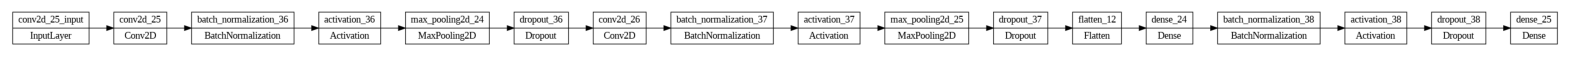

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 6, 1498, 32)       320       
                                                                 
 batch_normalization_36 (Ba  (None, 6, 1498, 32)       128       
 tchNormalization)                                               
                                                                 
 activation_36 (Activation)  (None, 6, 1498, 32)       0         
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 3, 749, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 3, 749, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 1, 747, 64)      

In [ ]:
# from keras.utils import plot_model
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# # Assuming create_cnn_model function is defined as above
# model = create_cnn_model([8, 1500, 1])

# # Save the model diagram temporarily
# temp_file = 'temp_model.png'
# plot_model(model, to_file=temp_file, show_shapes=False, show_layer_names=True,rankdir='LR')

# # Read and display the image with a larger figure size
# img = mpimg.imread(temp_file)
# plt.figure(figsize=(20, 6))  # Adjust the figure size as needed
# plt.imshow(img)
# plt.axis('off')  # Hide the axis
# plt.show()

# os.remove(temp_file)

# model.summary()

In [ ]:
frequencies = np.array([0, 0, 0, 0, 0, 0, 1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14,
       14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19,
       19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22,
       22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25,
       25, 25, 25, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28,
       28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 31,
       31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33,
       34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36,
       36, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39,
       39, 39])

accuracies = []
losses = []
for fold_index, (train_data_list, test_data) in enumerate(loso_splits):
    print(f"Training on Fold {fold_index + 1}")
    # Define the model for this fold
    model = create_cnn_model(input_shape=(8, 1500, 1))
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model on each subject's data in the training set
    for subject_data in train_data_list:
        # print(subject_data.targets)
        X_train = subject_data.data
        y_train = to_categorical(subject_data.targets, num_classes=40)
        # Fit the model with callbacks
        X_test = test_data.data # Adjust based on your data structure
        y_test = to_categorical(frequencies, num_classes=40)
        history = model.fit(X_train, y_train,
                    epochs=2,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy for Fold {fold_index + 1}: {test_accuracy}")
    print(f"Test Loss for Fold {fold_index + 1}: {test_loss}")

    accuracies.append(test_accuracy)
    losses.append(test_loss)

240
Training on Fold 1
Epoch 1/2
4/4 [==============================] - 10s 321ms/step - loss: 4.1101 - accuracy: 0.0458 - val_loss: 9.9440 - val_accuracy: 0.0292 - lr: 0.0010
Epoch 2/2
4/4 [==============================] - 0s 65ms/step - loss: 1.9522 - accuracy: 0.5833 - val_loss: 7.4680 - val_accuracy: 0.0333 - lr: 0.0010
Epoch 1/2
4/4 [==============================] - 0s 115ms/step - loss: 3.5948 - accuracy: 0.1208 - val_loss: 6.1089 - val_accuracy: 0.0500 - lr: 0.0010
Epoch 2/2
4/4 [==============================] - 0s 66ms/step - loss: 1.6799 - accuracy: 0.6375 - val_loss: 4.4612 - val_accuracy: 0.0792 - lr: 0.0010
Epoch 1/2
4/4 [==============================] - 0s 115ms/step - loss: 3.0167 - accuracy: 0.1917 - val_loss: 3.4950 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 2/2
4/4 [==============================] - 0s 78ms/step - loss: 1.4129 - accuracy: 0.7417 - val_loss: 2.9903 - val_accuracy: 0.2583 - lr: 0.0010
Epoch 1/2
4/4 [==============================] - 0s 121ms/step - lo

In [ ]:
print(accuracies)
print(losses)

avg_accuracy = np.average(accuracies)
avg_loss = np.average(losses)

print(avg_accuracy, avg_loss)

[0.9291666746139526, 0.875, 0.8999999761581421, 0.9541666507720947, 0.9708333611488342, 0.9958333373069763, 0.9416666626930237, 0.9916666746139526, 0.9041666388511658, 0.9583333134651184, 0.7458333373069763, 0.9791666865348816, 0.9583333134651184, 0.6208333373069763, 0.987500011920929, 0.8833333253860474, 0.9916666746139526, 0.9541666507720947, 0.8583333492279053, 0.7875000238418579, 0.8291666507720947, 0.9541666507720947, 0.6000000238418579, 0.9333333373069763, 0.9624999761581421, 0.987500011920929, 0.9750000238418579, 0.9291666746139526, 0.8833333253860474, 0.8083333373069763, 0.9958333373069763, 1.0, 0.4000000059604645, 0.987500011920929, 0.9458333253860474]
[0.6769084334373474, 0.8731772899627686, 0.894130527973175, 0.26011139154434204, 0.299731582403183, 0.08518611639738083, 0.3922405242919922, 0.09966005384922028, 0.5983685255050659, 0.6259922385215759, 1.2355847358703613, 0.4914899170398712, 0.4008817970752716, 1.7749253511428833, 0.17547403275966644, 0.8188514709472656, 0.11822

In [ ]:
def calculate_itr(num_targets, accuracy, selection_time):
    if num_targets <= 1 or accuracy <= 0 or selection_time <= 0:
        raise ValueError("Invalid input values for ITR calculation.")
    if accuracy > 1:
        raise ValueError("Accuracy cannot be greater than 1.")

    # Calculate terms in the ITR formula
    term1 = np.log2(num_targets)

    if accuracy == 1:
    # If accuracy is 100%, term2 and term3 are not needed
        itr = term1 * (60 / selection_time)
    else:
      term2 = accuracy * np.log2(accuracy)
      term3 = (1 - accuracy) * np.log2((1 - accuracy) / (num_targets - 1))

    # Calculate ITR in bits per minute
      itr = (term1 + term2 + term3) * (60 / selection_time)
    return itr



# Calculate ITR
itr = calculate_itr(40, avg_accuracy, 5)
print("ITR: bits/min", itr)


for avg_accuracy in accuracies:
    # Calculate ITR
    itr = calculate_itr(40, avg_accuracy, 5)
    print(f"Subject { + 1} ITR: {itr:.2f} bits/min")

ITR: bits/min 56.78154879907765
Subject 1 ITR: 54.94 bits/min
Subject 1 ITR: 49.41 bits/min
Subject 1 ITR: 51.89 bits/min
Subject 1 ITR: 57.74 bits/min
Subject 1 ITR: 59.73 bits/min
Subject 1 ITR: 63.13 bits/min
Subject 1 ITR: 56.31 bits/min
Subject 1 ITR: 62.50 bits/min
Subject 1 ITR: 52.32 bits/min
Subject 1 ITR: 58.22 bits/min
Subject 1 ITR: 37.93 bits/min
Subject 1 ITR: 60.79 bits/min
Subject 1 ITR: 58.22 bits/min
Subject 1 ITR: 28.33 bits/min
Subject 1 ITR: 61.91 bits/min
Subject 1 ITR: 50.23 bits/min
Subject 1 ITR: 62.50 bits/min
Subject 1 ITR: 57.74 bits/min
Subject 1 ITR: 47.81 bits/min
Subject 1 ITR: 41.43 bits/min
Subject 1 ITR: 45.11 bits/min
Subject 1 ITR: 57.74 bits/min
Subject 1 ITR: 26.84 bits/min
Subject 1 ITR: 55.39 bits/min
Subject 1 ITR: 58.72 bits/min
Subject 1 ITR: 61.91 bits/min
Subject 1 ITR: 60.25 bits/min
Subject 1 ITR: 54.94 bits/min
Subject 1 ITR: 50.23 bits/min
Subject 1 ITR: 43.25 bits/min
Subject 1 ITR: 63.13 bits/min
Subject 1 ITR: 63.86 bits/min
Subject 